# Actividad 3 - Segmentación de Imagenes

---
Asignatura: **Percepción Computacional**

Equipo: **1021H**

Integrantes: ...

---

## Segmentación de Imagenes - Usando torchvision

Copiado del repositorio de Ayrton

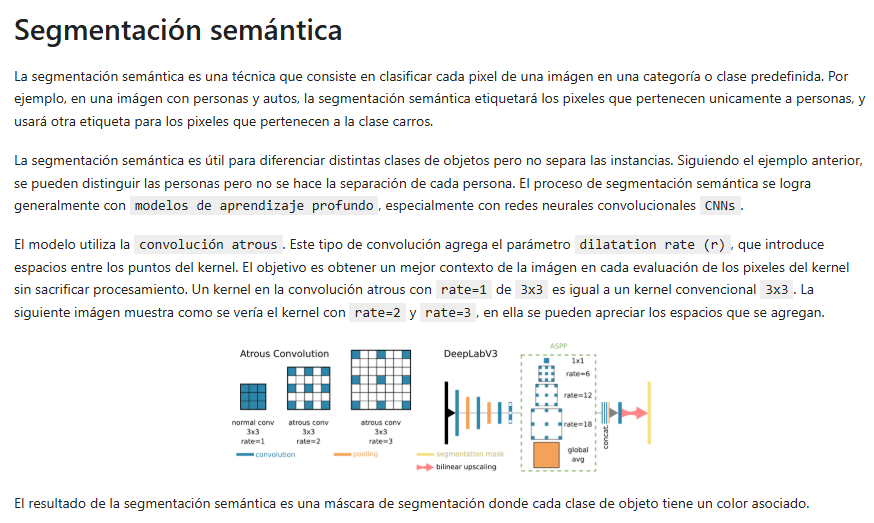

## Segmentación Semantica con LRASPP Mobilenet

### ¿Qué es lraspp_mobilenet_v3_large?

Es un modelo de **segmentación semántica eficiente** implementado en `torchvision.models.segmentation`, que combina:

    Un backbone ligero: MobileNetV3-Large

    Un decodificador rápido: LR-ASPP (Lite Reduced Atrous Spatial Pyramid Pooling)

Está diseñado para **buen rendimiento en dispositivos móviles o con recursos limitados**, manteniendo buena precisión.

### MobileNetV3-Large

Es una **red convolucional eficiente** que sirve como **extractor de características** (encoder/backbone).

#### Características clave:

    · Utiliza depthwise separable convolutions (menos operaciones).
    · Introduce squeeze-and-excitation (SE) blocks para mejorar la atención por canal.
    · Viene en dos variantes:
        · MobileNetV3-Small: más compacto.
        · MobileNetV3-Large: más potente (el que se mostrará en este ejemplo).
    · Diseñado por Google para tareas de visión en dispositivos móviles.

**Rol en el modelo**: extraer representaciones profundas y compactas de la imagen.

### LR-ASPP (Lite Reduced Atrous Spatial Pyramid Pooling)

Es una variante ligera de ASPP (usada en DeepLab), diseñada para **segmentación eficiente**.

#### ¿Qué hace?

    · Usa dilatación (atrous convolutions) para capturar información en diferentes escalas.
    · Reemplaza el costoso decodificador de DeepLabV3 con una versión más ligera y rápida.
    · Fusión de:
        · Low-level features: detalles finos
        · High-level features: contexto general

**Rol en el modelo**: produce la **máscara de segmentación final** de manera eficiente.

### COCO_WITH_VOC_LABELS_V1 (en torchvision.models.segmentation)

Este es un conjunto de **pesos preentrenados** (`weights`) que puedes usar al cargar modelos como `fcn_resnet50`, `deeplabv3_resnet101`, `lraspp_mobilenet_v3_large`, etc. en PyTorch.

#### ¿Qué significa?

    · El modelo fue entrenado en el dataset COCO (Common Objects in Context)
    · Pero usando solo las 21 clases del dataset PASCAL VOC, no las 91+ clases de COCO
    · Esto se hace para hacerlo compatible con evaluaciones o flujos de trabajo basados en VOC

#### ¿Qué contiene este conjunto de pesos?

    · Backbone preentrenado en ImageNet
    · Segmentador entrenado sobre imágenes COCO, usando solo las categorías que coinciden con VOC

#### Clases que incluye

```['background', 'aeroplane', 'bicycle', 'bird', 'boat', 'bottle', 'bus', 'car', 'cat', 'chair', 'cow', 'diningtable', 'dog', 'horse', 'motorbike', 'person', 'pottedplant', 'sheep', 'sofa', 'train', 'tvmonitor']```

### Implementación

#### Imports

In [1]:
from torchvision.io.image import decode_image
from torchvision.models.segmentation import LRASPP_MobileNet_V3_Large_Weights, lraspp_mobilenet_v3_large
from torchvision.transforms.functional import to_pil_image
import torchvision.transforms as transforms
import torch
import matplotlib.pyplot as plt
import numpy as np

#### Preparación del modelo

In [2]:
# Validamos si nuestra computadora soporta CUDA o solo CPU y lo guardamos en una variable
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

In [3]:
# Usamos los pesos del modelo pre entrenado e iniciamos el modelo indicando el DEVICE que usará.
weights = LRASPP_MobileNet_V3_Large_Weights.COCO_WITH_VOC_LABELS_V1;
model = lraspp_mobilenet_v3_large(weights=weights).to(DEVICE)

# Activamos el modo de evaluación del modelo, esto implica cambiar el comportamiento interno de las capas.
_ = model.eval()

#### Funciones útiles

In [12]:
# open_tensor_image: función que nos ayuda a abrir una imagen y devuelve un torch.Tensor con la forma [C, H, W] (canal, alto, ancho)
# inputs:
#    path: ruta de la imagen
def open_tensor_image(path, as_binary=False):
    # Abrimos la imagen como tensor usando decode_image
    img = decode_image(path)

    if as_binary:
        return to_pil_image(img).convert('1')
    
    # si la imagen tiene 4 canales, sobreescribimos para solo dejar 3.
    if img.shape[0] == 4:
        img = img[:3, :, :]

    return img

# process_tensor_image: función que nos ayuda a pre procesar una imagen torch.Tensor. Devuelve la imagen normalizada.
# inputs:
#    img: imagen del tipo torch.Tensor
def process_tensor_image(img):
    # Creamos un pipeline de transformaciones para usar con la imagen.
    transform = transforms.Compose([
        # Convertimos los valores a float para su posterior normalización
        transforms.ConvertImageDtype(torch.float),
        # Operación para normalizar la imagen.
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                             std=[0.229, 0.224, 0.225])
    ])

    # Transformamos la imagen y el resultado lo asignamos a una nueva variable.
    img_tensor = transform(img)

    # Agregamos una nueva dimensión en la posición 0 ya que es el formato que espera cualquier modelo de pytorch. Despues movemos el tensor al dispositivo donde será procesado, "cuda" o "cpu".
    img_tensor = img_tensor.unsqueeze(0).to(DEVICE)

    return img_tensor

# image_segmentation: Función que nos ayuda a ejecutar el modelo sobre una imagen dada. Devuelve la mascara binarizada y la mascara predicha por el modelo.
# inputs:
#     img: imagen del tipo torch.Tensor
def image_segmentation(img):
    # Obtenemos las clases desde los pesos y convertimos la lista en un diccionario.
    class_to_idx = {cls: idx for (idx, cls) in enumerate(weights.meta["categories"])}

    # Obtenemos el indice de la clase __background__
    category = class_to_idx["__background__"]

    # Le indicamos a PyTorch que no almacene los gradientes, para mejorar el desempeño de la predicción.
    with torch.no_grad():
        # Usamos el modelo para hacer la predicción y obtenemos el resultado.
        prediction = model(img)["out"]

        # Usamos softmax a lo largo del eje dim=1.
        prediction_image = prediction.softmax(dim=1)

        # Obtenemos la mascara predicha por el modelo usando la categoria obtenida anteriormente.
        predicted_mask = prediction_image[0, category].cpu()

    # Creamos una mascara binaria con todo aquello que tenga menos del 95% de probabilidad de ser el background de la imagen.
    binary_mask = (predicted_mask < 0.95).float()

    # Retornamos la mascara binarizada y la mascara predicha.
    return binary_mask, predicted_mask.detach().cpu().numpy()

# show_images: Función que nos permite mostrar la imagen original, la mascara binarizada, la mascara predicha y el ground truth
# inputs:
#    img: Imagen original.
#    binary_mask: Imagen de mascara binarizada.
#    predicted_mask: Imagen de mascara predicha
#    ground_truth: Imagen de ground truth
def show_images(img, binary_mask, predicted_mask, ground_truth):
    plt.figure(figsize=(20,4))
    plt.subplot(1,4,1)
    plt.imshow(img.permute(1, 2, 0).cpu().numpy())
    plt.title("Imagen original")
    plt.subplot(1,4,2)
    plt.title(f"Ground Truth")
    plt.imshow(ground_truth, cmap='gray')
    plt.subplot(1,4,3)
    plt.title(f"Máscara binarizada")
    plt.imshow(binary_mask, cmap='gray')
    plt.subplot(1,4,4)
    plt.title(f"Mascara predicha")
    plt.imshow(predicted_mask, cmap='gray')
    plt.show()

# calculate_iou: Función que nos permite calcular que tanto se sobrepone la mascara binarizada sobre el ground truth.
# inputs:
#    pred: mascara predicha
#    gt: mascara Ground truth
def calculate_iou(pred, gt):
    pred_np = pred.cpu().numpy() if torch.is_tensor(pred) else pred
    gt_np = gt.cpu().numpy() if torch.is_tensor(gt) else gt
    intersection = np.logical_and(pred_np, gt_np).sum()
    union = np.logical_or(pred_np, gt_np).sum()
    return intersection / union if union != 0 else 0.0

#### Aplicamos el modelo a la imagen car1.png

Porcentaje de predicción:  0.41264437088475514


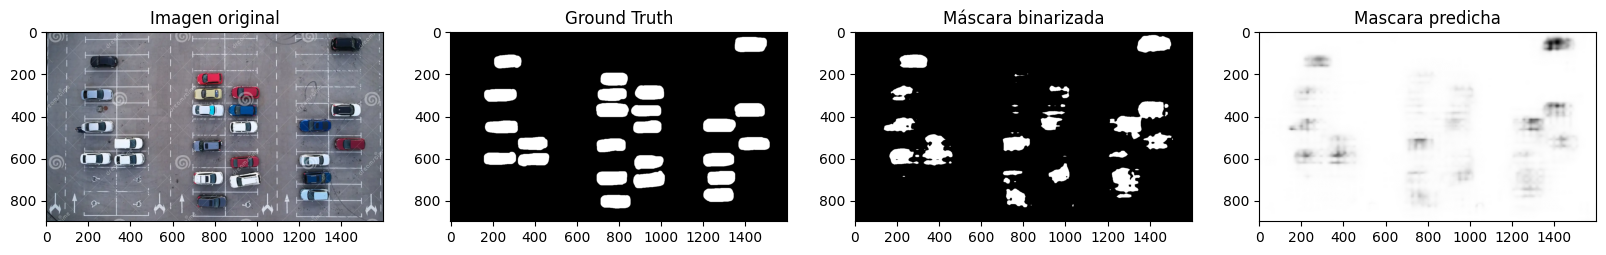

In [14]:
car1 = open_tensor_image('../imagenes/object_detection/car1.png')
car1_ground_truth = open_tensor_image('../imagenes/object_detection/car1_ground_truth.png', True)
car1_preproc = process_tensor_image(car1)
binary_mask, predicted_mask = image_segmentation(car1_preproc)
print('Porcentaje de predicción: ', calculate_iou(binary_mask, car1_ground_truth))
show_images(car1, binary_mask, predicted_mask, car1_ground_truth)

#### Aplicamos el modelo a la imagen car2.png

Porcentaje de predicción:  0.42843266973101546


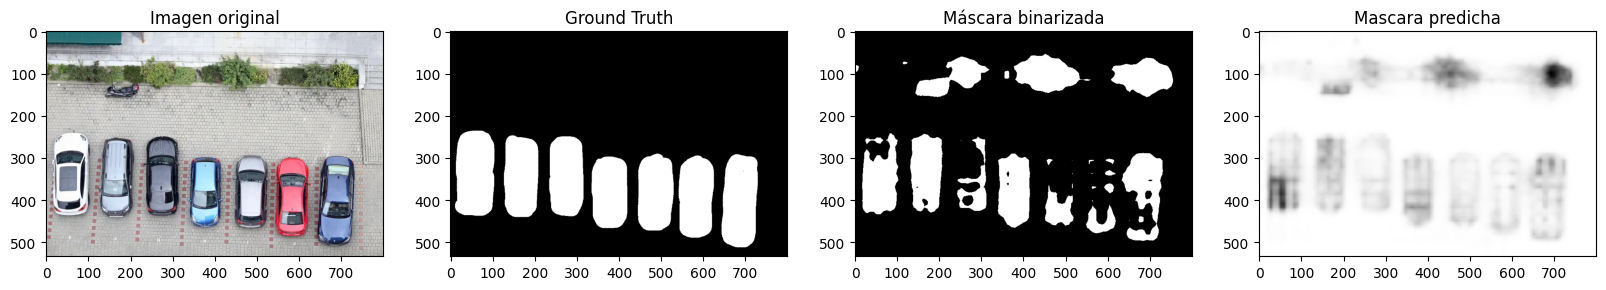

In [16]:
car2 = open_tensor_image('../imagenes/object_detection/car2.png')
car2_ground_truth = open_tensor_image('../imagenes/object_detection/car2_ground_truth.png', True)
car2_preproc = process_tensor_image(car2)
binary_mask, predicted_mask = image_segmentation(car2_preproc)
print('Porcentaje de predicción: ', calculate_iou(binary_mask, car2_ground_truth))
show_images(car2, binary_mask, predicted_mask, car2_ground_truth)

#### Aplicamos el modelo a la imagen car3.jpg

Porcentaje de predicción:  0.3613038202181262


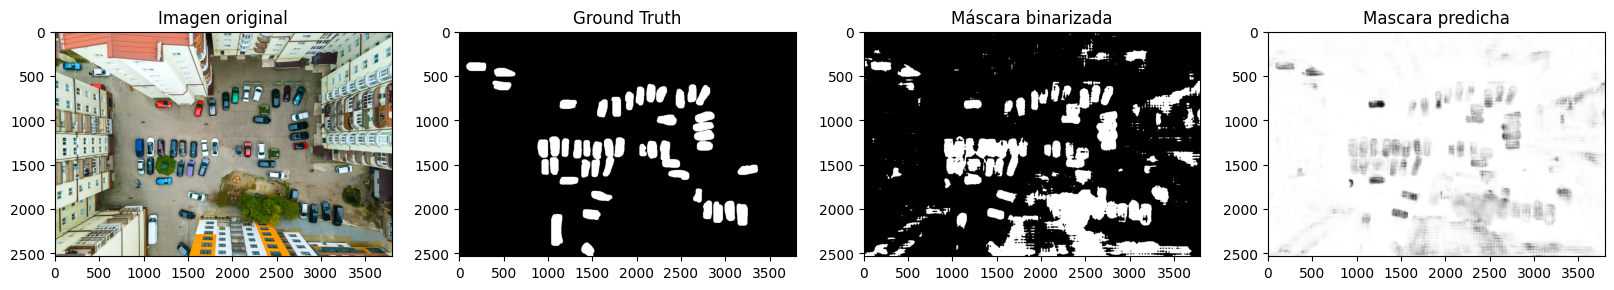

In [17]:
car3 = open_tensor_image('../imagenes/object_detection/car3.jpg')
car3_ground_truth = open_tensor_image('../imagenes/object_detection/car3_ground_truth.png', True)
car3_preproc = process_tensor_image(car3)
binary_mask, predicted_mask = image_segmentation(car3_preproc)
print('Porcentaje de predicción: ', calculate_iou(binary_mask, car3_ground_truth))
show_images(car3, binary_mask, predicted_mask, car3_ground_truth)

In [17]:
# Nos permite liberar la memoria utilizada en la GPU y limpiar el caché.
torch.cuda.empty_cache()

### Conclusión

En este experimento se empleó el modelo **`lraspp_mobilenet_v3_large`** utilizando el conjunto de pesos **`COCO_WITH_VOC_LABELS_V1`**. Durante las pruebas, se observó que la clase **`__background__`** proporcionó mejores resultados visuales en comparación con la clase **`car`**, la cual no logró detectar adecuadamente los vehículos cuando las imágenes se tomaron desde una perspectiva satelital.

Adicionalmente, se exploraron múltiples modelos alternativos, tales como **FCN** con pesos entrenados en COCO, así como variantes de **U-Net**, **U-Net++**, **PSPNet** y **UPerNet**, todos ellos con distintos *encoders* (incluyendo `ImageNet`). Sin embargo, ninguno logró segmentar correctamente los automóviles desde esta vista aérea, lo que sugiere que los modelos preentrenados disponibles actualmente no están optimizados para este tipo de imágenes satelitales, y probablemente requerirían un ajuste fino (*fine-tuning*) o entrenamiento especializado sobre un conjunto de datos más específico.
